## IMPORTS

In [1]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from numpy import array
from sklearn import svm, model_selection
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, accuracy_score, confusion_matrix, roc_curve, f1_score, auc, \
    precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# READ CSV

In [2]:
from sklearn.tree import DecisionTreeClassifier
df=pd.read_csv('Data/CVD.csv',sep=';')
df['age']=(df['age']/365).round().astype('int')
df.drop(['id'],axis=1,inplace=True)
df['BMI'] = df['weight']/((df['height']/100)**2)


In [3]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


## DATA ANALYSIS

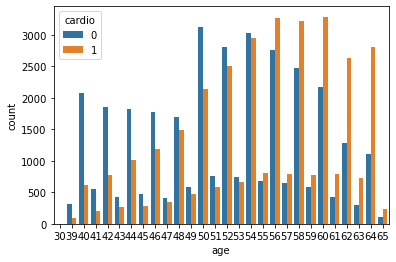

In [4]:
sns.countplot(data=df, x=df.age, hue=df.cardio)

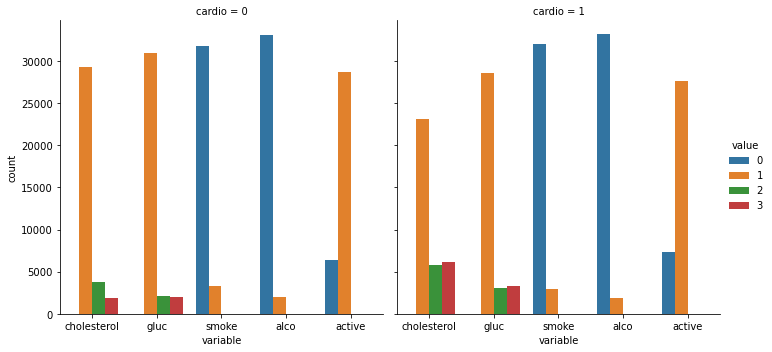

In [5]:
df_long = pd.melt(df, id_vars=['cardio'], value_vars=['cholesterol','gluc', 'smoke', 'alco', 'active'])
sns.catplot(x="variable", hue="value", col="cardio",
                data=df_long, kind="count");

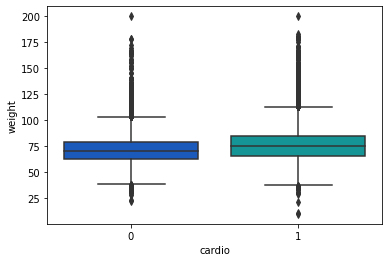

In [6]:
sns.boxplot(x='cardio',y='weight',data=df,palette='winter')

# DATA PREPROCESSING

In [7]:
df.isnull().values.any()

False

In [8]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700,27.556513
std,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003,6.091511
min,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.471784
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.374068
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000,30.222222
max,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,298.666667


In [9]:
df[df.ap_lo>df.ap_hi]

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
228,48,2,183,98.0,160,1100,1,2,1,0,1,1,29.263340
241,60,2,157,60.0,160,1000,2,1,0,0,0,1,24.341758
260,50,1,150,83.0,140,800,1,1,0,0,1,1,36.888889
329,64,1,176,63.0,160,1000,2,2,0,0,0,1,20.338326
345,51,1,154,81.0,140,1000,2,1,0,0,1,1,34.154158
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69771,64,1,167,81.0,160,1000,1,1,0,0,1,1,29.043709
69872,60,1,152,56.0,160,1000,1,1,0,0,1,1,24.238227
69878,58,2,168,95.0,160,1000,1,1,0,0,1,1,33.659297
69885,61,2,166,78.0,170,1000,1,1,0,0,0,0,28.305995


In [10]:
df.sort_values('BMI')

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
33817,59,2,178,11.0,130,90,1,1,0,0,1,1,3.471784
57858,52,2,165,10.0,180,1100,2,2,0,0,1,1,3.673095
29488,56,2,177,22.0,120,80,1,1,1,1,1,0,7.022248
60188,60,1,162,21.0,120,80,2,1,0,0,1,1,8.001829
26806,64,1,157,23.0,110,80,1,1,0,0,1,0,9.331007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29157,52,1,60,69.0,110,70,1,1,0,0,0,0,191.666667
23913,52,1,81,156.0,140,90,1,1,0,0,1,0,237.768633
22723,64,1,55,81.0,130,90,1,1,0,0,1,1,267.768595
27384,42,1,80,178.0,140,90,3,3,0,0,1,1,278.125000


In [11]:
df.drop(df[(df['height'] > df['height'].quantile(0.99)) | (df['height'] < df['height'].quantile(0.01))].index,inplace=True)
df.drop(df[(df['weight'] > df['weight'].quantile(0.99)) | (df['weight'] < df['weight'].quantile(0.01))].index,inplace=True)
df.drop(df[(df['ap_hi'] > df['ap_hi'].quantile(0.99)) | (df['ap_hi'] < df['ap_hi'].quantile(0.01))].index,inplace=True)
df.drop(df[(df['ap_lo'] > df['ap_lo'].quantile(0.99)) | (df['ap_lo'] < df['ap_lo'].quantile(0.01))].index,inplace=True)

df = df[df.ap_hi >= df.ap_lo]
df.drop(df[(df['BMI'] > df['BMI'].quantile(0.99))| (df['BMI'] < df['BMI'].quantile(0.01))].index,inplace=True)

print(df)

       age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0       50       2     168    62.0    110     80            1     1      0   
1       55       1     156    85.0    140     90            3     1      0   
2       52       1     165    64.0    130     70            3     1      0   
3       48       2     169    82.0    150    100            1     1      0   
4       48       1     156    56.0    100     60            1     1      0   
...    ...     ...     ...     ...    ...    ...          ...   ...    ...   
69994   58       1     165    80.0    150     80            1     1      0   
69995   53       2     168    76.0    120     80            1     1      1   
69997   52       2     183   105.0    180     90            3     1      0   
69998   61       1     163    72.0    135     80            1     2      0   
69999   56       1     170    72.0    120     80            2     1      0   

       alco  active  cardio        BMI  
0         0       1   

In [12]:
df.describe()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,BMI
count,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000,64536.000000
mean,53.344319,1.350378,164.498296,73.660606,126.397468,81.265449,1.358606,1.222248,0.086990,0.052622,0.803923,0.493616,27.246120
std,6.752775,0.477092,7.280147,12.355998,15.781663,9.066314,0.674656,0.568528,0.281823,0.223279,0.397030,0.499963,4.434556
min,30.000000,1.000000,147.000000,48.000000,90.000000,60.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.252620
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,23.875115
50%,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,26.298488
75%,58.000000,2.000000,170.000000,81.000000,140.000000,90.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,29.996713
max,65.000000,2.000000,184.000000,117.000000,180.000000,150.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,41.502301


### ONE HOT ENCODING

In [13]:
values = array(df['cholesterol'])

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [14]:
a=[]
b=[]
c=[]
for i in onehot_encoded:
  a.append(i[0])
  b.append(i[1])
  c.append(i[2])
df['chol1'] = a
df['chol2']=b
df['chol3']=c

df.drop(['cholesterol'],axis=1,inplace=True)

In [15]:
gluc=pd.get_dummies(df['gluc'],prefix='gluc')
df=pd.concat([df,gluc],axis=1)
df.drop(['gluc'],axis=1,inplace=True)

In [16]:
df['BMI']=df['BMI'].round().astype('int')
df['chol1']=df['chol1'].astype('int')
df['chol2']=df['chol2'].astype('int')
df['chol3']=df['chol3'].astype('int')

In [17]:
cols=df.columns.drop(['cardio'])
cols

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 'alco',
       'active', 'BMI', 'chol1', 'chol2', 'chol3', 'gluc_1', 'gluc_2',
       'gluc_3'],
      dtype='object')

In [18]:
df.drop(df[df.duplicated(cols)].index,inplace=True)

In [19]:
df.count()

age       59166
gender    59166
height    59166
weight    59166
ap_hi     59166
ap_lo     59166
smoke     59166
alco      59166
active    59166
cardio    59166
BMI       59166
chol1     59166
chol2     59166
chol3     59166
gluc_1    59166
gluc_2    59166
gluc_3    59166
dtype: int64

In [20]:
df

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,chol1,chol2,chol3,gluc_1,gluc_2,gluc_3
0,50,2,168,62.0,110,80,0,0,1,0,22,1,0,0,1,0,0
1,55,1,156,85.0,140,90,0,0,1,1,35,0,0,1,1,0,0
2,52,1,165,64.0,130,70,0,0,0,1,24,0,0,1,1,0,0
3,48,2,169,82.0,150,100,0,0,1,1,29,1,0,0,1,0,0
4,48,1,156,56.0,100,60,0,0,0,0,23,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,58,1,165,80.0,150,80,0,0,1,1,29,1,0,0,1,0,0
69995,53,2,168,76.0,120,80,1,0,1,0,27,1,0,0,1,0,0
69997,52,2,183,105.0,180,90,0,1,0,1,31,0,0,1,1,0,0
69998,61,1,163,72.0,135,80,0,0,0,1,27,1,0,0,0,1,0


In [21]:
df['gender'].replace(2,0,inplace=True)

In [22]:
down=df[(df.cardio==1)&(df.active==1)&(df.smoke==0)&(df.gluc_1==1)&(df.BMI<25)&(80<df.ap_lo)&(df.ap_lo<90)&(120<df.ap_hi)&(df.ap_hi<140)&(df.chol1==1)].index

In [23]:
df.drop(down,inplace=True)

In [24]:
down2=df[(df.cardio==0)&(df.active==0)&(df.gluc_3==1)&(df.BMI>30)&((90<df.ap_lo)|(df.ap_lo<80))&((140<df.ap_hi)|(df.ap_hi<120))&(df.chol3==1)].index

In [25]:
df.drop(down2,inplace=True)

In [26]:
df[(df.cardio==0)&(df.active==0)&(df.BMI>35)&((90<df.ap_lo)|(df.ap_lo<80))&((140<df.ap_hi)|(df.ap_hi<120))&((df.chol3==1)|(df.gluc_3==1))]

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,chol1,chol2,chol3,gluc_1,gluc_2,gluc_3
1240,60,1,164,96.0,90,60,0,0,0,0,36,0,0,1,1,0,0
9774,50,1,151,81.0,90,70,0,0,0,0,36,1,0,0,0,0,1
10704,60,1,160,104.0,141,70,0,0,0,0,41,0,1,0,0,0,1
12881,62,1,149,90.0,160,110,0,0,0,0,41,0,0,1,1,0,0
54033,42,0,152,92.0,100,70,0,0,0,0,40,1,0,0,0,0,1


In [27]:
df.drop(df[(df.BMI>40)&(df.cardio==0)].index,inplace=True)

In [28]:
df.groupby('gender').count()

,age,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,BMI,chol1,chol2,chol3,gluc_1,gluc_2,gluc_3
gender,,,,,,,,,,,,,,,,
0,21379,21379,21379,21379,21379,21379,21379,21379,21379,21379,21379,21379,21379,21379,21379,21379
1,37683,37683,37683,37683,37683,37683,37683,37683,37683,37683,37683,37683,37683,37683,37683,37683


In [29]:
down3=df[(df.gluc_3==1)&(df.chol3==1)&(df.cardio==0)&((df.ap_hi>140)|(df.ap_hi<120))].index

In [30]:
df.drop(down3,inplace=True)

In [31]:
#df.drop(df[(df.BMI>30)&(df.cardio==0)&(df.chol3==1)&(df.age>60)&(df.active==0)].index,inplace=True)

In [32]:
#df.drop(df[(df.BMI<25)&(df.cardio==1)&(df.chol1==1)&(df.age<45)&(df.active==1)&(df.ap_lo>80)].index,inplace=True)

In [33]:
dflow0=df[(df.age<45)&(df.active==1)&(df.chol1==1)&(df.cardio==0)&(df.smoke==0)&(df.alco==0)&(df.gluc_1==1)&(df.BMI<=35)]
dflow1=df[(df.age<45)&(df.active==0)&(df.chol1==0)&(df.gluc_1==0)]
dfmid0=df[(df.cardio==0)&(df.age>=45)&(df.age<=58)&((df.chol1==1)&(df.active==1))&(df.gluc_1==1)&(df.smoke==0)&(df.alco==0)&(df.BMI<=30)]
dfmid1=df[(df.cardio==1)&(df.age>=45)&(df.age<=58)&((df.chol1==0)|(df.active==0))]
dfhi1=df[(df.age>60)&(df.cardio==1)&(df.chol1==0)]
dfhi0=df[(df.age>60)&(df.cardio==0)&(df.chol1==1)&(df.smoke==0)&(df.alco==0)&(df.gluc_1==1)&(df.BMI<=30)]
final=dflow0.append([dflow1,dfmid0,dfmid1,dfhi0,dfhi1])
bad=df[(df.cardio==0)&(df.active==0)&(df.chol1==0)]
bad1=df[(df.cardio==1)&(df.active==1)&(df.chol1==1)]
newfinal=final.append(bad)
newfinal1=newfinal.append(bad1)
final=newfinal1

## TEST TRAIN SPLIT

In [34]:
predictors = final.drop(["cardio",'BMI'],axis=1)
target = final['cardio']

X_train,X_test,Y_train,Y_test = train_test_split(predictors,target,test_size=0.2,random_state=1,stratify=target)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=1,stratify=Y_train)

In [35]:
print(Y_train.mean(),Y_test.mean())

0.6568423531258585 0.6569132236594248


In [36]:
from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
X_train=sc_X.fit_transform(X_train)
X_val=sc_X.fit_transform(X_val)
X_test=sc_X.fit_transform(X_test)

### BOOSTING

#### GRADIENT BOOSTING

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
depth = 5  #@param {type: "slider", min: 0, max: 100}
gb = GradientBoostingClassifier(random_state=42,max_depth=depth)
gb.fit(X_train, Y_train)
print("Accuracy on training set: {:.3f}".format(gb.score(X_train, Y_train)))
print("Accuracy on val set: {:.3f}".format(gb.score(X_val, Y_val)))

Accuracy on training set: 0.861
Accuracy on val set: 0.853


In [39]:
print("Accuracy on test set: {:.3f}".format(gb.score(X_test, Y_test)))


Accuracy on test set: 0.851


Done
### AUC score and precision recall graph

In [40]:
def plotting(true,pred):
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    precision,recall,threshold = precision_recall_curve(true,pred[:,1])
    ax[0].plot(recall,precision,'g--')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title("Average Precision Score : {}".format(average_precision_score(true,pred[:,1])))
    fpr,tpr,threshold = roc_curve(true,pred[:,1])
    ax[1].plot(fpr,tpr)
    ax[1].set_title("AUC Score is: {}".format(auc(fpr,tpr)))
    ax[1].plot([0,1],[0,1],'k--')
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')



<Figure size 432x288 with 0 Axes>

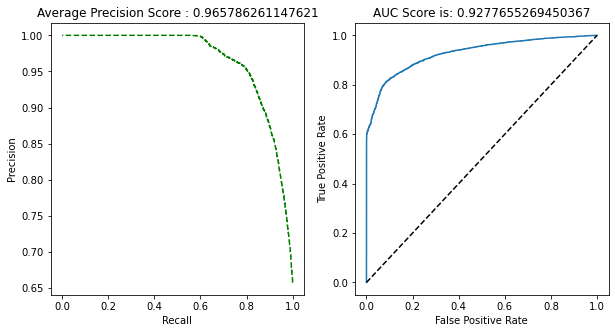

In [41]:
plt.figure()
plotting(Y_test,gb.predict_proba(X_test))

In [44]:
print("Saving model")
filename = 'Models/CVD.pickle'
pickle.dump(gb, open(filename, 'wb'))

new_gb = pickle.load(open(filename, 'rb'))
print("Accuracy on training set: {:.3f}".format(new_gb.score(X_train, Y_train)))
print("Accuracy on val set: {:.3f}".format(new_gb.score(X_val, Y_val)))
print("Accuracy on test set: {:.3f}".format(new_gb.score(X_test, Y_test)))


Saving model
Accuracy on training set: 0.861
Accuracy on val set: 0.853
Accuracy on test set: 0.851
